In [1]:
using Revise

In [2]:
using LazySets

In [3]:
using ModelVerification

In [4]:
using PyCall
using CSV
using ONNX
using Flux
using DataFrames

In [5]:
include("vnnlib_parser.jl")

read_vnnlib_simple (generic function with 1 method)

In [6]:

function onnx_to_nnet(onnx_file)
    pushfirst!(PyVector(pyimport("sys")."path"), @__DIR__)
    nnet = pyimport("NNet")
    use_gz = split(onnx_file, ".")[end] == "gz"
    if use_gz
        onnx_file = onnx_file[1:end-3]
    end
    nnet_file = onnx_file[1:end-4] * "nnet"
    isfile(nnet_file) && return
    nnet.onnx2nnet(onnx_file, nnetFile=nnet_file)
end

function verify_an_instance(onnx_file, spec_file, timeout)
    use_gz = split(onnx_file, ".")[end] == "gz"
    nnet_file = use_gz ? onnx_file[1:end-7] * "nnet" : onnx_file[1:end-4] * "nnet"
    net = ModelVerification.read_nnet(nnet_file)
    ###### TODO: change this ad-hoc remedy for nnet read ######
    net.layers[1] = ModelVerification.Layer(net.layers[1].weights, net.layers[1].bias, ModelVerification.Id())
    flux_model = Flux.Chain(net)
    n_in = size(net.layers[1].weights)[2]
    n_out = length(net.layers[end].bias)
    specs = read_vnnlib_simple(spec_file, n_in, n_out)
    current_time = 0
    for spec in specs
        X_range, Y_cons = spec
        lb = [bd[1] for bd in X_range]
        ub = [bd[2] for bd in X_range]
        X = Hyperrectangle(low = lb, high = ub)
        res = nothing
        A = []
        b = []
        for Y_con in Y_cons
            A = hcat(Y_con[1]...)'
            b = Y_con[2]
            Yc = HPolytope(A, b)
            Y = Complement(Yc)
            search_method = BFS(max_iter=10, batch_size=13)
            split_method = Bisect(1)
            prop_method = Crown()
            problem = Problem(flux_model, X, Y)
            res = @timed verify(search_method, split_method, prop_method, problem)
            current_time += res.time 
            if(current_time >= timeout)
                println("timed out at:", current_time)
                return "unknown"
            end
            res.value.status == :violated && (return "violated")
            res.value.status == :unknown && (return "unknown")
        end
    end
    return "holds"
end

function run_all(instance_csv, result_csv)
    file = CSV.File(instance_csv, header=false)
    dirpath = dirname(instance_csv)
    df = DataFrame()
    for (index,row) in enumerate(file)
        println("Instance $index.")
        onnx_file = joinpath(dirpath, row[1])
        vnnlib_file = joinpath(dirpath, row[2])
        timeout = row[3]
        onnx_to_nnet(onnx_file)
        result = @timed verify_an_instance(onnx_file, vnnlib_file, timeout)
        println(result)
        push!(df, result)
    end
    CSV.write(result_csv, df)
end

run_all (generic function with 1 method)

In [91]:
onnx_file = "../../vnncomp2021/benchmarks/acasxu/ACASXU_run2a_4_5_batch_2000.onnx"
spec_file = "../../vnncomp2021/benchmarks/acasxu/prop_10.vnnlib"
timeout = 116
verify_an_instance(onnx_file, spec_file, timeout)

forward
in
out
false
forward
in
out
false


forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false
forward
in
out
false


"violated"

In [8]:
run_all("../../vnncomp2021/benchmarks/acasxu/acasxu_instances.csv", "./result.csv")

Instance 1.


PyCall.PyError: PyError (PyImport_ImportModule

The Python package NNet could not be imported by pyimport. Usually this means
that you did not install NNet in the Python version being used by PyCall.

PyCall is currently configured to use the Python version at:

/home/tianhao/miniconda3/envs/torch/bin/python

and you should use whatever mechanism you usually use (apt-get, pip, conda,
etcetera) to install the Python package containing the NNet module.

One alternative is to re-configure PyCall to use a different Python
version on your system: set ENV["PYTHON"] to the path/name of the python
executable you want to use, run Pkg.build("PyCall"), and re-launch Julia.

Another alternative is to configure PyCall to use a Julia-specific Python
distribution via the Conda.jl package (which installs a private Anaconda
Python distribution), which has the advantage that packages can be installed
and kept up-to-date via Julia.  As explained in the PyCall documentation,
set ENV["PYTHON"]="", run Pkg.build("PyCall"), and re-launch Julia. Then,
To install the NNet module, you can use `pyimport_conda("NNet", PKG)`,
where PKG is the Anaconda package that contains the module NNet,
or alternatively you can use the Conda package directly (via
`using Conda` followed by `Conda.add` etcetera).

) <class 'ModuleNotFoundError'>
ModuleNotFoundError("No module named 'NNet'")


In [9]:
using Plots

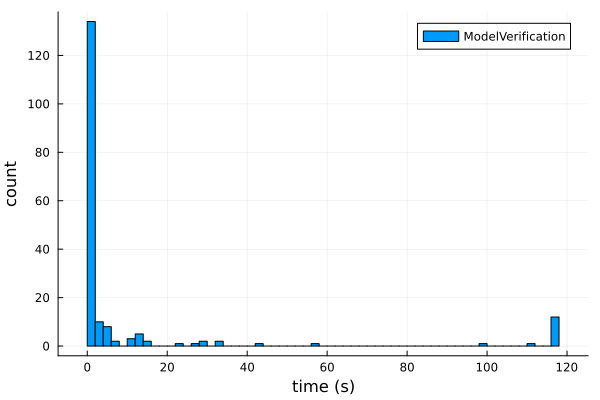

In [10]:
mv_df = DataFrame(CSV.File("./result.csv", header=true))
mv_df[mv_df.time .> 116, :time] .= 116
t = histogram(mv_df.time, bins=100, label="ModelVerification")
xlabel!("time (s)")
ylabel!("count")
display(t)

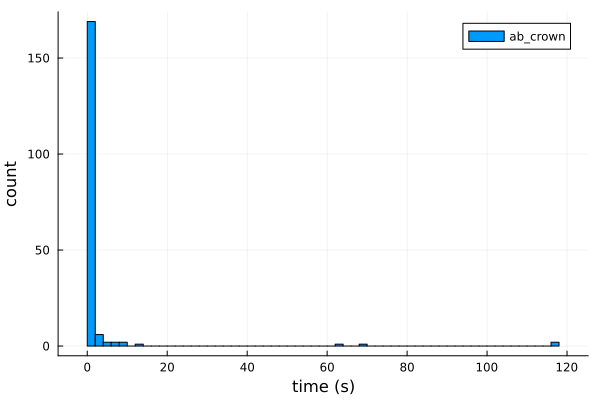

In [11]:
ab_df = DataFrame(CSV.File("./abcrown_result.csv", header=true))
ab_df[!,:value] = convert.(String15, ab_df[!,:value])
ab_df[ab_df.value .== "safe", :value] .= "holds"
ab_df[ab_df.value .== "unsafe", :value] .= "violated"
t = histogram(ab_df.time, bins=100, label="ab_crown")
xlabel!("time (s)")
ylabel!("count")
display(t)

In [12]:
println(sum(ab_df.value .== "holds"))
println(sum(ab_df.value .== "violated"))
println(sum(ab_df.value .== "unknown"))

139
45
2


In [13]:
println(sum(mv_df.value .== "holds"))
println(sum(mv_df.value .== "violated"))
println(sum(mv_df.value .== "unknown"))

129
45
12


In [14]:
[mv_df[mv_df.value .!= ab_df.value, :value], ab_df[mv_df.value .!= ab_df.value, :value]]

2-element Vector{AbstractVector{String15}}:
 ["unknown", "unknown", "unknown", "unknown", "violated", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown"]
 ["holds", "holds", "holds", "holds", "unknown", "holds", "holds", "holds", "holds", "holds", "violated", "holds"]